In [1]:
from PIL import Image, ImageDraw
import numpy as np
import os
import torch 
import my_transforms

from my_bbox import get_bounding_box

In [2]:
from torchvision.transforms import ToTensor

In [3]:
def generate_bitmask(image_size, bbox):
        """
        Generate a bitmask from a bounding box annotation file.
        :param image_size: Size of the image (width, height).
        :param bbox: Tuple (xmin, ymin, xmax, ymax) representing the bounding box.
        :return: Bitmask as a NumPy array.
        """
        width, height = image_size
        mask = Image.new('L', (width, height), 0)  # Blank mask

        x_min, y_min, x_max, y_max = bbox
        draw = ImageDraw.Draw(mask)
        draw.rectangle([x_min, y_min, x_max, y_max], fill=1)

        return np.array(mask, dtype=np.float32)

In [4]:
transform = my_transforms.get_resnet_augmented_transforms()

In [43]:
from torchvision import transforms
augment = True

path = 'data/Stanford40/random_splits/train/drinking/drinking_051.jpg'

image_id = os.path.basename(path).split('.')[0]
# Get the corresponding bounding box annotation
_, bbox = get_bounding_box(image_id)

image = Image.open(path).convert('RGB')
original_width, original_height = image.size

resize = transforms.Resize((224, 224))

# apply resize to the image
image = resize(image)

# Resize the bounding box to the same proportions
resized_width, resized_height = image.size

width_scale = resized_width / original_width
height_scale = resized_height / original_height

x_min, y_min, x_max, y_max = bbox

x_min = int(x_min * width_scale)
y_min = int(y_min * height_scale)
x_max = int(x_max * width_scale)
y_max = int(y_max * height_scale)

bbox = (x_min, y_min, x_max, y_max)

# must apply color jitter before converting to tensor and adding 4th channel
if augment:
    jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    image = jitter(image)

bitmask = generate_bitmask(image.size, bbox)

# Convert bitmask to a tensor and add it as the 4th channel
bitmask_tensor = torch.tensor(bitmask, dtype=torch.float32).unsqueeze(0)
if not isinstance(image, torch.Tensor):  # Convert image to tensor if it's not already
    image = ToTensor()(image)
image = torch.cat((image, bitmask_tensor), dim=0)

# ToTensor normalizes pixels to [0, 1], but further augments don't care about that so it's safe to apply it here

mean = np.array([0.46824582, 0.44051382, 0.40057998, 0])
std = np.array([0.24759944, 0.23944832, 0.24277655, 1])

if augment:
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.Normalize(mean=mean, std=std),
    ])
else:
    transform = transforms.Compose([
        transforms.Normalize(mean=mean, std=std),
    ])

# Apply transformations (if any) to the image AFTER adding the bitmask
image = transform(image)

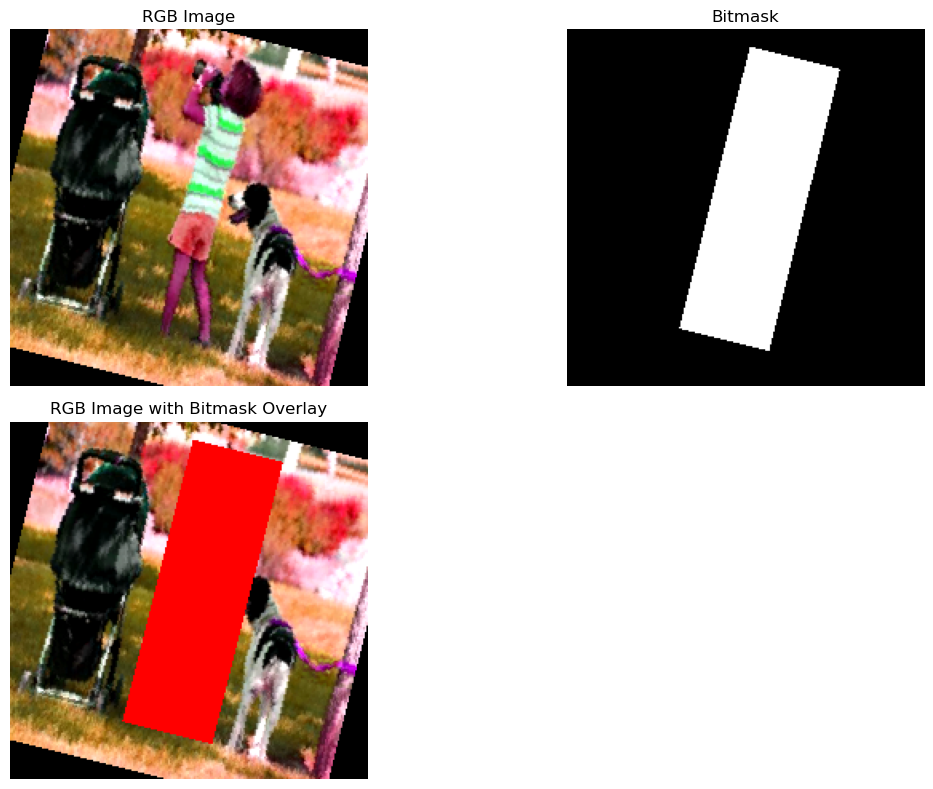

In [44]:
import matplotlib.pyplot as plt

denormalize = transforms.Compose([
    transforms.Normalize(mean= -1 * mean/std, std=[1 / s for s in std]),
])

image = denormalize(image)

image = (image * 255).clamp(0, 255).byte()

# Extract the first three channels (RGB) and the fourth channel (bitmask)
rgb_image = image[:3, :, :].permute(1, 2, 0).numpy()
bitmask = image[3, :, :].numpy()

# Plot the RGB image
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(rgb_image)
plt.title('RGB Image')
plt.axis('off')

# Plot the bitmask
plt.subplot(2, 2, 2)
plt.imshow(bitmask, cmap='gray')
plt.title('Bitmask')
plt.axis('off')

# Overlay the bitmask on the RGB image
overlay = rgb_image.copy()
overlay[bitmask > 0.5] = [255, 0, 0]  # Red color for the mask

plt.subplot(2, 2, 3)
plt.imshow(overlay)
plt.title('RGB Image with Bitmask Overlay')
plt.axis('off')

plt.tight_layout()
plt.show()